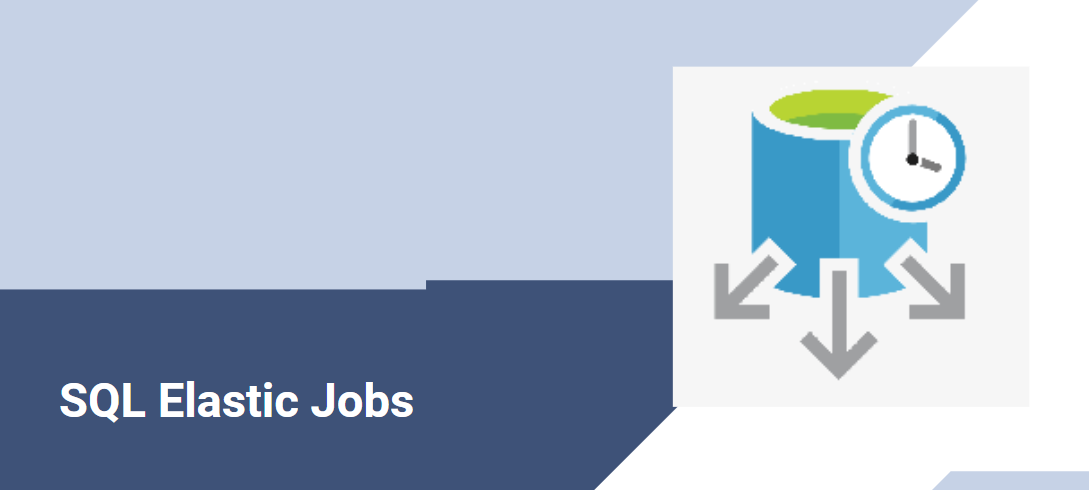

[https://docs.microsoft.com/pt-br/azure/azure-sql/database/job-automation-overview?view=azuresql](https://docs.microsoft.com/pt-br/azure/azure-sql/database/job-automation-overview?view=azuresql)

[https://docs.microsoft.com/en-us/azure/azure-sql/database/elastic-jobs-tsql-create-manage?view=azuresql](https://docs.microsoft.com/en-us/azure/azure-sql/database/elastic-jobs-tsql-create-manage?view=azuresql)

https://www.sqlshack.com/elastic-jobs-in-azure-sql-database/  

https://www.mssqltips.com/sqlservertip/6420/create-azure-sql-database-scheduled-jobs/  

https://www.sqlshack.com/azure-sql-elastic-job-agent/

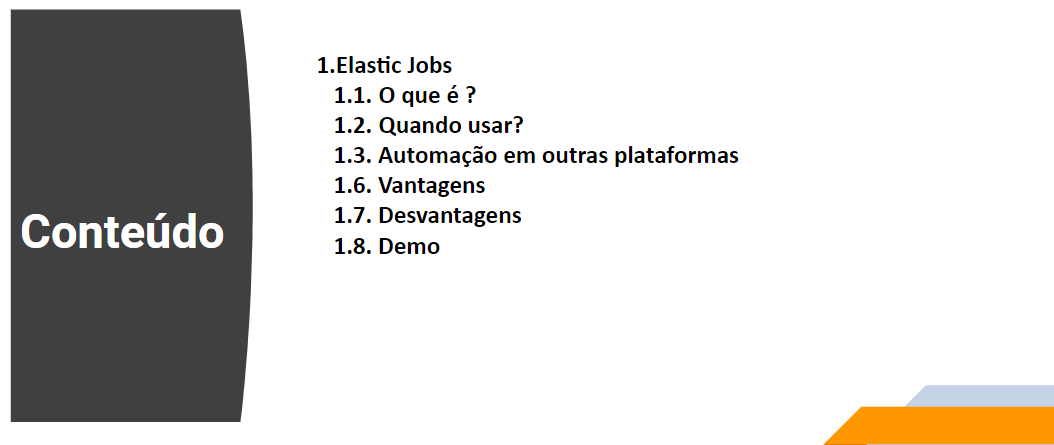

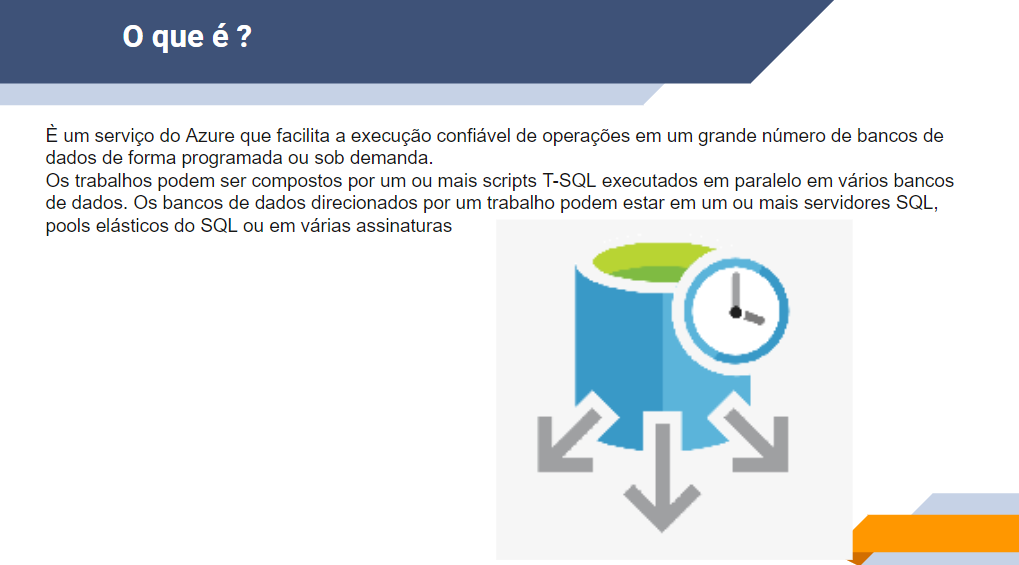

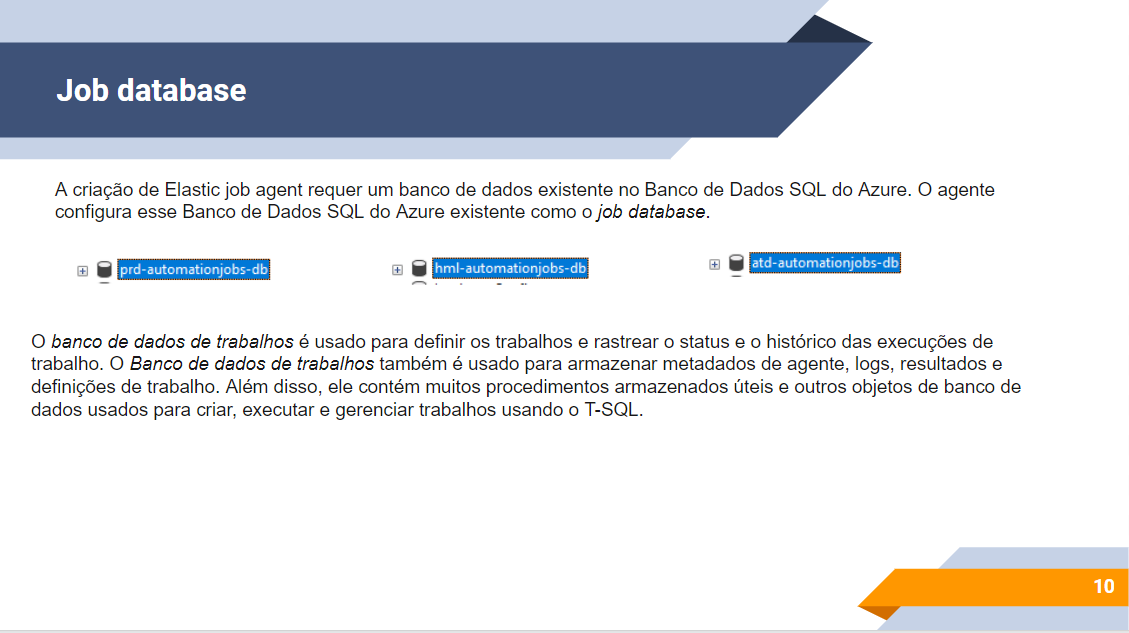

# **<mark>Implementação</mark>**

1. # <mark>Passo 1) Criar o banco de dados para hospedar o JOB</mark>
    
2. # <mark>\--Deve estar conectado em master</mark>

In [1]:

--DROP DATABASE [hml-sqlautomationjobs-db]

CREATE DATABASE [hml-sqlautomationjobs-db]


Commands completed successfully.

Total execution time: 00:01:00.399

# <mark>**\# Criação e configuração do Elastc JOB**</mark>

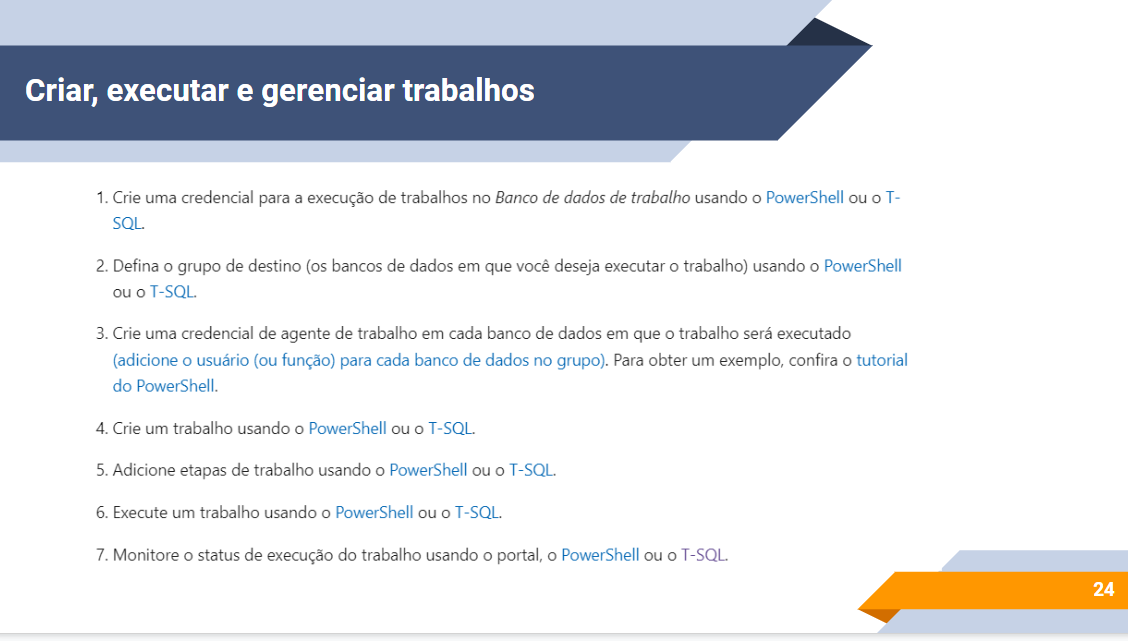

# **<mark>\## Criação de bases espelhos</mark>**

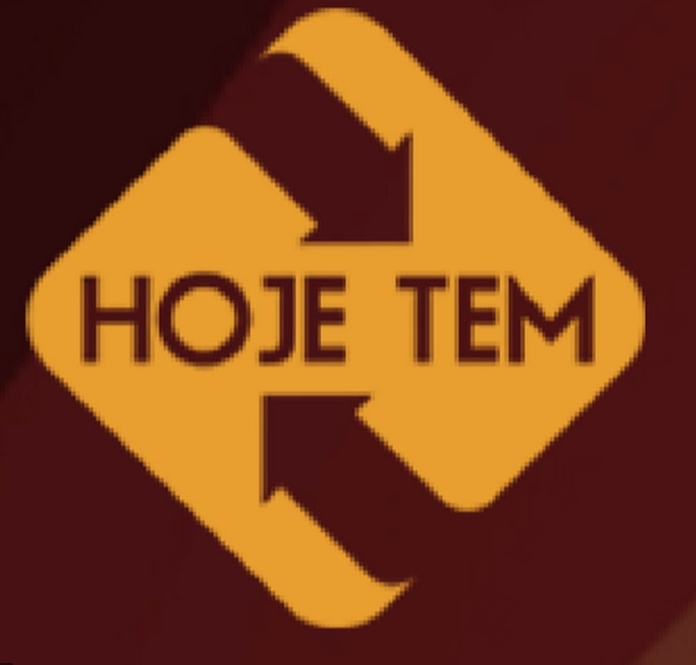

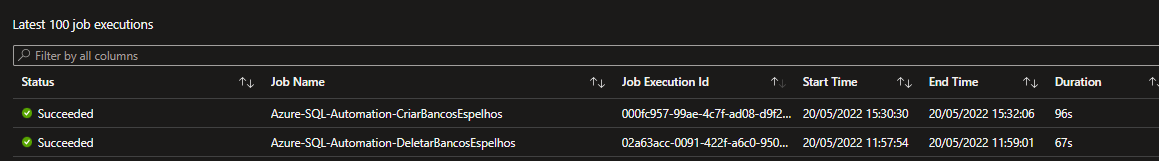

# <mark>**1) Tabelas Envolvidas**</mark>

## **<mark>\## Tabela de Databases espelhados</mark>**

In [ ]:
CREATE TABLE [Espelhamento].[DatabasesEspelhados]
(
    [DatabaseId] [INT] NOT NULL IDENTITY(1, 1),
    [DatabaseName] [VARCHAR](250) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL,
    [Periodicidade] [VARCHAR](30) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL,
    [DatabasePoolName] [VARCHAR](200) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL
) ON [PRIMARY];
GO
ALTER TABLE [Espelhamento].[DatabasesEspelhados]
ADD CONSTRAINT [PK_EspelhamentoDatabasesEspelhadosDatabaseId]
    PRIMARY KEY CLUSTERED ([DatabaseId]);
GO
ALTER TABLE [Espelhamento].[DatabasesEspelhados]
ADD CONSTRAINT [UQ_EspelhamentoDatabasesEspelhadosDatabaseName]
    UNIQUE NONCLUSTERED ([DatabaseName]);
GO


In [ ]:
SELECT * FROM [Espelhamento].[DatabasesEspelhados] AS [DE]
ORDER BY DE.Periodicidade


## **<mark>\## Tabelas para Logs</mark>**

In [ ]:
CREATE TABLE [Automation].[Logs]
(
    [IdLog] [INT] NOT NULL
        CONSTRAINT [DEF_AutomationLogs]
            DEFAULT (NEXT VALUE FOR [Automation].[SEQ_AutomationLogs]),
    [Rotina] [VARCHAR](200) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL,
    [DataInicioExecucao] [DATETIME2](2) NOT NULL,
    [DataTerminoExecucao] [DATETIME2](2) NOT NULL,
    [Parametros] [VARCHAR](300) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL,
    [DatabaseName] [VARCHAR](150) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL,
    [Comando] [VARCHAR](300) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL,
    [Status] [VARCHAR](10) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL,
    [Detalhe] [VARCHAR](500) COLLATE SQL_Latin1_General_CP1_CI_AS NOT NULL
) ON [PRIMARY];
GO

In [ ]:
SELECT L.IdLog,
       L.Rotina,
       L.DataInicioExecucao,
       L.DataTerminoExecucao,
       TimeElepsed = DATEDIFF(SECOND, L.DataInicioExecucao, L.DataTerminoExecucao),
       L.Parametros,
       L.DatabaseName,
       L.Comando,
       L.Status,
       L.Detalhe
FROM Automation.Logs AS L;

# <mark>**\# procedures envolvidas**</mark>

### <mark>**\# Criar cópias**</mark>

In [ ]:
ALTER PROCEDURE Automation.uspCriarCopiasEspelhos
AS
BEGIN

    /*Executa a rotina full somente no sabado WEEKDAY = 7 */
    DECLARE @Day TINYINT = DATEPART(WEEKDAY, DATEADD(HOUR, -3, GETDATE()));

    --SET @Day =2


    DECLARE @ExecutarRotinaFull BIT = IIF(@Day = 7, 1, 0);


    /*não executar a deleção no domingo*/
    IF (@Day <> 1)
    BEGIN
        EXEC Automation.uspGerarBancosEspelhos @DeletarCopias = 0,                        -- bit
                                               @SpecificNameDatabase = NULL,              -- varchar(200)
                                               @ExecutarRotinaFull = @ExecutarRotinaFull; -- bit
    END;

END;
GO


### <mark>**\# Deletar cópias**</mark>

In [ ]:
ALTER PROCEDURE Automation.uspDeletarEspelhamentoBancoDados
AS
BEGIN

    /*Executa a rotina full somente no na segunda feira as 01:00:02 da manha */
    DECLARE @Day TINYINT = DATEPART(WEEKDAY, DATEADD(HOUR, -3, GETDATE()));

	--SET @Day  =2

    DECLARE @ExecutarRotinaFull BIT = IIF(@Day = 2, 1, 0);

	/*não executar a deleção no domingo*/
	IF (@Day <> 1)
	BEGIN
		EXEC Automation.uspGerarBancosEspelhos @DeletarCopias = 1,           -- bit
											   @SpecificNameDatabase = NULL, -- varchar(200)
											   @ExecutarRotinaFull = @ExecutarRotinaFull;      -- bit		
	END;

END;
GO

### <mark>**\## Rotina que gera efetivamente os bancos**</mark>

In [ ]:
ALTER PROCEDURE Automation.uspGerarBancosEspelhos
(
    @DeletarCopias BIT = 0,
    @SpecificNameDatabase VARCHAR(200) = NULL,
    @ExecutarRotinaFull BIT = 0
)
AS
BEGIN

    --DECLARE @DeletarCopias BIT = 1,
    --        @SpecificNameDatabase VARCHAR(200) = NULL,
    --        @ExecutarRotinaFull BIT = 0;


    DROP TABLE IF EXISTS #databasesBaseCursor;


    CREATE TABLE #databasesBaseCursor
    (
        [DatabaseName] VARCHAR(128) NOT NULL,
        [DatabaseEspelhoName] VARCHAR(128) NOT NULL,
        DatabasePoolName VARCHAR(200) NOT NULL
    );



    DECLARE @TypeLogs AS Automation.TypeLogs;



    DECLARE @Parametros VARCHAR(200) =
            (
                SELECT X.*
                FROM
                (
                    SELECT @DeletarCopias AS DeletarCopias,
                           @ExecutarRotinaFull AS ExecutarRotinaFull
                ) AS X
                FOR JSON AUTO
            );




    DECLARE @Detalhe VARCHAR(500) = '';




    /* declare variables */
    DECLARE @databaseName VARCHAR(200);
    DECLARE @databaseEspelhoName VARCHAR(200);
    DECLARE @DatabasePoolName VARCHAR(200);

    IF (@ExecutarRotinaFull = 1)
    BEGIN
        INSERT INTO #databasesBaseCursor
        SELECT DE.DatabaseName,
               DatabaseEspelhoName = CONCAT(DE.DatabaseName, '-ESPELHO'),
               DE.DatabasePoolName
        FROM Espelhamento.DatabasesEspelhados AS DE
        WHERE DE.DatabaseName = ISNULL(@SpecificNameDatabase, DE.DatabaseName);
    END;
    ELSE
    BEGIN
        INSERT INTO #databasesBaseCursor
        SELECT DE.DatabaseName,
               DatabaseEspelhoName = CONCAT(DE.DatabaseName, '-ESPELHO'),
               DE.DatabasePoolName
        FROM Espelhamento.DatabasesEspelhados AS DE
        WHERE DE.Periodicidade = 'Diariamente'
              AND DE.DatabaseName = ISNULL(@SpecificNameDatabase, DE.DatabaseName);
    END;



    DECLARE cursor_Espelhamentos CURSOR FAST_FORWARD READ_ONLY FOR
    SELECT D.[DatabaseName],
           [DatabaseEspelhoName],
           D.DatabasePoolName
    FROM #databasesBaseCursor AS D;

    OPEN cursor_Espelhamentos;

    FETCH NEXT FROM cursor_Espelhamentos
    INTO @databaseName,
         @databaseEspelhoName,
         @DatabasePoolName;

    WHILE @@FETCH_STATUS = 0
    BEGIN

        IF (@DeletarCopias = 0)
        BEGIN

            INSERT INTO @TypeLogs
            (
                Rotina,
                DataInicioExecucao,
                DataTerminoExecucao,
                Parametros,
                DatabaseName,
                Comando,
                Status,
                Detalhe
            )
            VALUES
            (   'Automation.uspCriarCopiasEspelhos', -- Rotina - varchar(200)
                SYSDATETIME(),                       -- DataInicioExecucao - datetime2(2)
                NULL,                                -- DataTerminoExecucao - datetime2(2)
                @Parametros,                         -- Parametros - varchar(300)
                @databaseName,                       -- DatabaseName - varchar(150)
                '',                                  -- Comando - varchar(300)
                '',                                  -- Status - varchar(10)
                ''                                   -- Detalhe - varchar(500)
                );

            DECLARE @Script VARCHAR(MAX)
                = CONCAT(
                            'CREATE DATABASE ',
                            QUOTENAME(@databaseEspelhoName),
                            ' AS COPY OF ',
                            QUOTENAME(@databaseName),
                            SPACE(2),
                            '(SERVICE_OBJECTIVE = ELASTIC_POOL( name =',
                            CHAR(34),
                            @DatabasePoolName,
                            CHAR(34),
                            ') );'
                        );


            BEGIN TRY

                EXEC (@Script);

                UPDATE @TypeLogs
                SET DataTerminoExecucao = SYSDATETIME(),
                    Comando = @Script,
                    Status = 'Sucesso',
                    Detalhe = 'Executado com Sucesso'
                WHERE DatabaseName = @databaseName;



            END TRY
            BEGIN CATCH

                SET @Detalhe =
                (
                    SELECT X.*
                    FROM
                    (
                        SELECT ERROR_NUMBER() AS ErrorNumber,
                               ERROR_SEVERITY() AS ErrorSeverity,
                               ERROR_STATE() AS ErrorState,
                               ERROR_PROCEDURE() AS ErrorProcedure,
                               ERROR_LINE() AS ErrorLine,
                               ERROR_MESSAGE() AS ErrorMessage
                    ) AS X
                    FOR JSON AUTO
                );

                UPDATE @TypeLogs
                SET DataTerminoExecucao = SYSDATETIME(),
                    Comando = @Script,
                    Status = 'Falha',
                    Detalhe = @Detalhe
                WHERE DatabaseName = @databaseName;


            END CATCH;

        END;
        ELSE
        BEGIN
            BEGIN TRY
                INSERT INTO @TypeLogs
                (
                    Rotina,
                    DataInicioExecucao,
                    DataTerminoExecucao,
                    Parametros,
                    DatabaseName,
                    Comando,
                    Status,
                    Detalhe
                )
                VALUES
                (   'Automation.uspDeletarEspelhamentoBancoDados', -- Rotina - varchar(200)
                    SYSDATETIME(),                                 -- DataInicioExecucao - datetime2(2)
                    NULL,                                          -- DataTerminoExecucao - datetime2(2)
                    @Parametros,                                   -- Parametros - varchar(300)
                    @databaseName,                                 -- DatabaseName - varchar(150)
                    '',                                            -- Comando - varchar(300)
                    '',                                            -- Status - varchar(10)
                    ''                                             -- Detalhe - varchar(500)
                    );

                DECLARE @ScriptDropDatabase VARCHAR(200) = CONCAT('DROP DATABASE ', QUOTENAME(@databaseEspelhoName));


                EXEC (@ScriptDropDatabase);
                UPDATE @TypeLogs
                SET DataTerminoExecucao = SYSDATETIME(),
                    Comando = @ScriptDropDatabase,
                    Status = 'Sucesso',
                    Detalhe = 'Executado com Sucesso'
                WHERE DatabaseName = @databaseName;


            END TRY
            BEGIN CATCH


                SET @Detalhe =
                (
                    SELECT X.*
                    FROM
                    (
                        SELECT ERROR_NUMBER() AS ErrorNumber,
                               ERROR_SEVERITY() AS ErrorSeverity,
                               ERROR_STATE() AS ErrorState,
                               ERROR_PROCEDURE() AS ErrorProcedure,
                               ERROR_LINE() AS ErrorLine,
                               ERROR_MESSAGE() AS ErrorMessage
                    ) AS X
                    FOR JSON AUTO
                );

                SELECT @ScriptDropDatabase;
                UPDATE @TypeLogs
                SET DataTerminoExecucao = SYSDATETIME(),
                    DatabaseName = @databaseName,
                    Comando = @ScriptDropDatabase,
                    Status = 'Falha',
                    Detalhe = @Detalhe
                WHERE DatabaseName = @databaseName;


            END CATCH;

        END;

        FETCH NEXT FROM cursor_Espelhamentos
        INTO @databaseName,
             @databaseEspelhoName,
             @DatabasePoolName;
    END;


    EXEC Automation.InsertIntoLogs @LogData = @TypeLogs;

    --SELECT * FROM @TypeLogs AS TL

    CLOSE cursor_Espelhamentos;
    DEALLOCATE cursor_Espelhamentos;
END;

GO


In [ ]:
IF(NOT EXISTS (
                  SELECT *
                    FROM jobs.jobsteps AS J
                   WHERE
                      J.job_name = 'Azure-SQL-Automation-DeletarBancosEspelhos'
                      AND J.step_name = 'deletarBancosEspelhos'
              )
  )
    BEGIN
        EXEC jobs.sp_add_jobstep @job_name = 'Azure-SQL-Automation-DeletarBancosEspelhos',
                                 @step_name = 'deletarBancosEspelhos',
                                 @max_parallelism = 1,
								 @command_type ='TSQL',
                                 @command = N'EXEC Automation.uspDeletarEspelhamentoBancoDados',
                                 @credential_name = 'JobExecuter',
                                 @retry_attempts = 3,
                                 @target_group_name = 'Azure-SQL-Automation';
    END;

In [ ]:
                    
IF(NOT EXISTS (
                  SELECT *
                    FROM jobs.jobsteps AS J
                   WHERE
                      J.job_name = 'Azure-SQL-Automation-CriarBancosEspelhos'
                      AND J.step_name = 'criarBancosEspelhos'
              )
  )
    BEGIN
        EXEC jobs.sp_add_jobstep @job_name = 'Azure-SQL-Automation-CriarBancosEspelhos',
                                 @step_name = 'criarBancosEspelhos',
                                 @max_parallelism = 1,
								 @command_type ='TSQL',
                                 @command = N'EXEC Automation.uspCriarCopiasEspelhos',
                                 @credential_name = 'JobExecuter',
                                 @retry_attempts = 3,
                                 @target_group_name = 'Azure-SQL-Automation';
    END;

In [ ]:

EXEC jobs.sp_update_job @job_name = 'Azure-SQL-Automation-DeletarBancosEspelhos',
                        @enabled = 1,
                        @schedule_interval_type = 'Days',
                        @schedule_interval_count = 1,
                        @schedule_start_time = N'20210327 03:03'; --N'20210327 04:00' (gtm -3)  =>> 00:30 da Manha



EXEC jobs.sp_update_job @job_name = 'Azure-SQL-Automation-CriarBancosEspelhos',
                        @enabled = 1,
                        @schedule_interval_type = 'Days',
                        @schedule_interval_count = 1,
                        @schedule_start_time = N'20210327 06:00'; --N'20210327 05:00'   (gtm -3)   =>> 3 da Manha



## <mark>**\## Execução do JOB**</mark>

In [ ]:
EXEC jobs.sp_start_job 'Azure-SQL-Automation-DeletarBancosEspelhos';